# 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime
import xgboost as xgb
import random
import warnings
import pickle
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from boruta import BorutaPy
from flask import Flask, request, Response
from platform import python_version
print(python_version())

3.8.11


## 0.1 Helper Funcions

In [2]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

def root_mean_squared_percentage_error(y, yhat):
    return np.sqrt(np.mean(np.square((y - yhat) / y)))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values #no curso ele usa a função .as_matrix() que foi descontinuada.
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr =  max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (k-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
#0 a 1 - Quanto mais perto do 0 menor a correlação / 1 maior a correlação

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width:100 !import;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

jupyter_settings()

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\n KFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name, 
                         'MAE CV': np.round(np.mean(mae_list), 2).astype('str') + '+/-' + np.round(np.std(mae_list), 2).astype('str'),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype('str') + '+/-' + np.round(np.std(mape_list), 2).astype('str'),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype('str') + '+/-' + np.round(np.std(rmse_list), 2).astype('str')},
                         index=[0])

Populating the interactive namespace from numpy and matplotlib


C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading data

In [5]:
df_sales_raw = pd.read_csv( 'dataset/train.csv', low_memory=False)
df_store_raw = pd.read_csv( 'dataset/store.csv', low_memory=False)

#merge - MAIN: SALES MERGING LEFT - Because all sales are related to a store.
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.to_csv('dataset/C1/c01_00_rossman.csv', index=False)

# 1.0 DESCRICAO DOS DADOS

In [6]:
# reading files - SALES + STORE
df1 = pd.read_csv('dataset/C1/c01_00_rossman.csv')

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
# analyzing the columns of DF
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Colums

In [9]:
# storing columns names
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

#renaming columns name
df1.columns = cols_new

In [10]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [11]:
print('Number of Rows: {}'.format (df1.shape[0]))
print('Number of Rows: {}'.format (df1.shape[1]))

Number of Rows: 1017209
Number of Rows: 18


## 1.3 Data Types

In [12]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [ ]:
# 1. eliminar as linhas que possuem NA - rápido e fácil / jogar fora dados
# 2. utilizar algoritmos de ML (mediana, média, regressão) - quando não há entendimento de negócio
# 3. Análise sobre a lógica do negócio

## 1.5 Fillout NA

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [16]:
# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [ ]:
df1.sample(5)

In [ ]:
df1.isna().sum()

## 1.6 Change Types

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [19]:
num_attributes = df1.select_dtypes(include=('int64', 'float64'))
cat_attributes = df1.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

In [ ]:
cat_attributes.sample(5)

### 1.7.1 Numerical Attibutes

In [20]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

n = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
n.columns = ['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
n

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [21]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


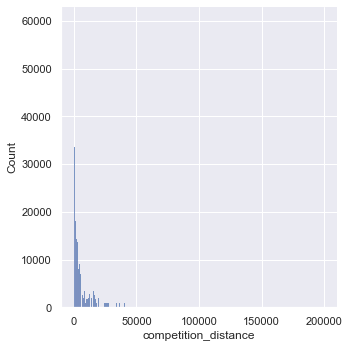

In [22]:
sns.displot(df1['competition_distance'])

### 1.7.2 Categorical Attibutes

In [23]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

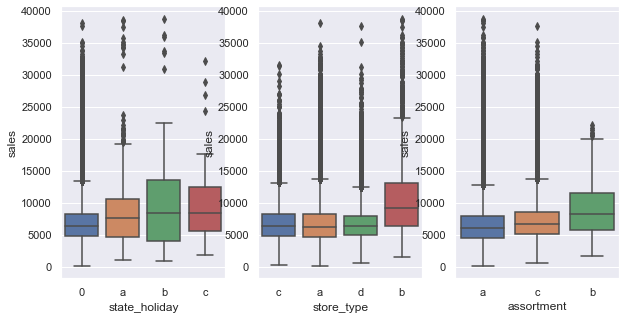

In [24]:
aux1=df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' , y='sales', data=aux1)
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type' , y='sales', data=aux1)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment' , y='sales', data=aux1)

In [25]:
df1.to_csv('dataset/C1/c01_01_rossman.csv', index=False)

# 2.0 FEATURE ENGINEERING

In [5]:
df2 = pd.read_csv('dataset/C1/c01_01_rossman.csv')

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 2.1 Mapa Mental de Hipótese

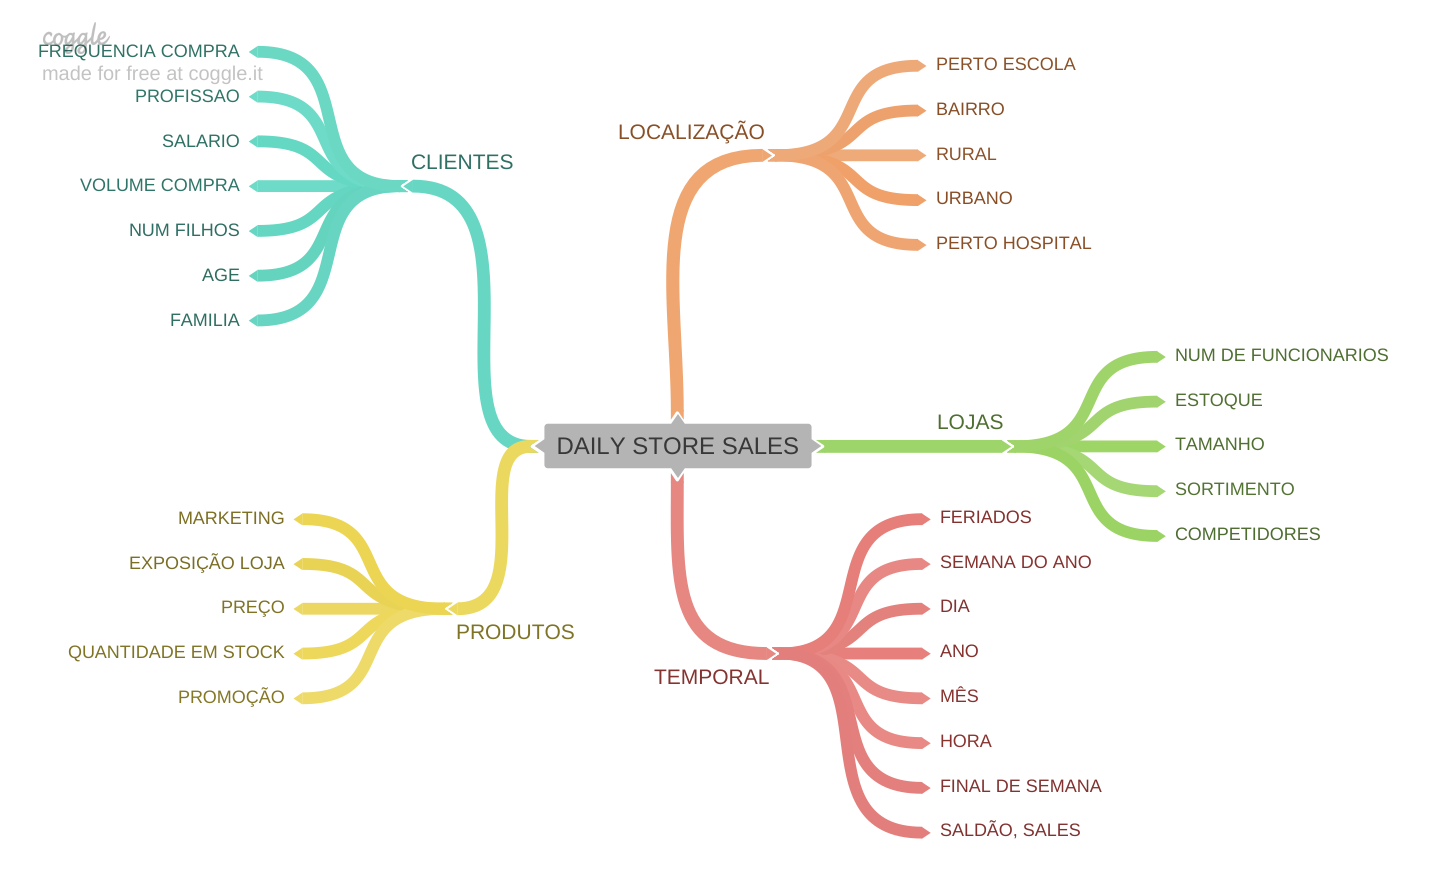

In [26]:
Image('img/DAILY_STORE_SALES.png')

## 2.2 Criação de Hipóteses

### 2.2.1 Hipótese Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipótese Produto

**1.** Lojas que investem mais no Marketing deveriam vender mais.

**2.** Lojas que expõe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**5.** Lojas com promoções mais agressivas (desconto maiores) deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveria vender mais.

**7.** Lojas com mais dias de prmoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipótese Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos nos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveria vender mais.

**5.** Lojas com mais dias de prmoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos nos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [19]:
df2['date'] = pd.to_datetime(df2['date'])

In [32]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
#PART1: FIND THE STARTING DATE OF WEEK CHOOSEN | PARTE2: TAKE 1 WEEK TO SEE THE START OF WEEK CHOSEN
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
#HOW MUCH WEEKS
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x=='a' else 'eastern_holiday' if x=='b' else 'christimas' if x=='c' else 'regular_day')

In [33]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [34]:
df2.to_csv('dataset/C1/c01_02_rossman.csv', index=False)

# 3.0 FILTRAGEM DE VARIÁVEIS

In [3]:
df3 = pd.read_csv('dataset/C1/c01_02_rossman.csv')

In [4]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das linhas

In [36]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [37]:
#retirado o customers porque não dá para fazer uma projeção, sem fazer um modelo para isso.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [38]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [39]:
df3.to_csv('dataset/C1/c01_03_rossman.csv', index=False)

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [4]:
df4 = pd.read_csv('dataset/C1/c01_03_rossman.csv')

In [39]:
df4.shape

(844338, 25)

## 4.1. ANÁLISE UNIVARIADA

### 4.1.1. RESPONSE VARIABLE

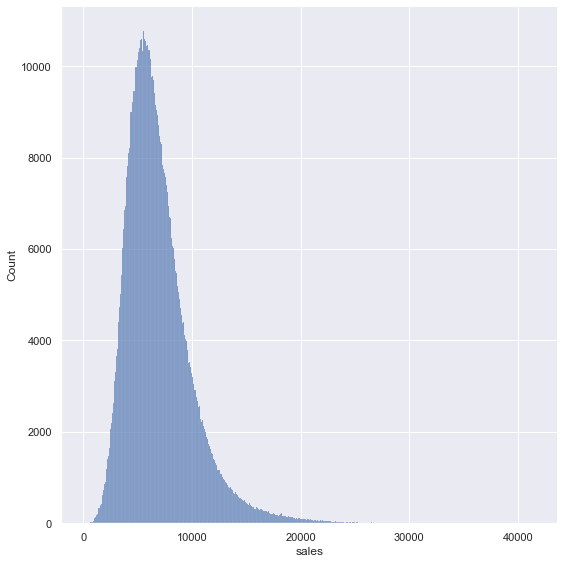

In [41]:
sns.set()
sns.set_theme(style="darkgrid")
sns.displot(df4['sales'], height=8)
plt.show()

### 4.1.2. NUMERICAL VARIABLE

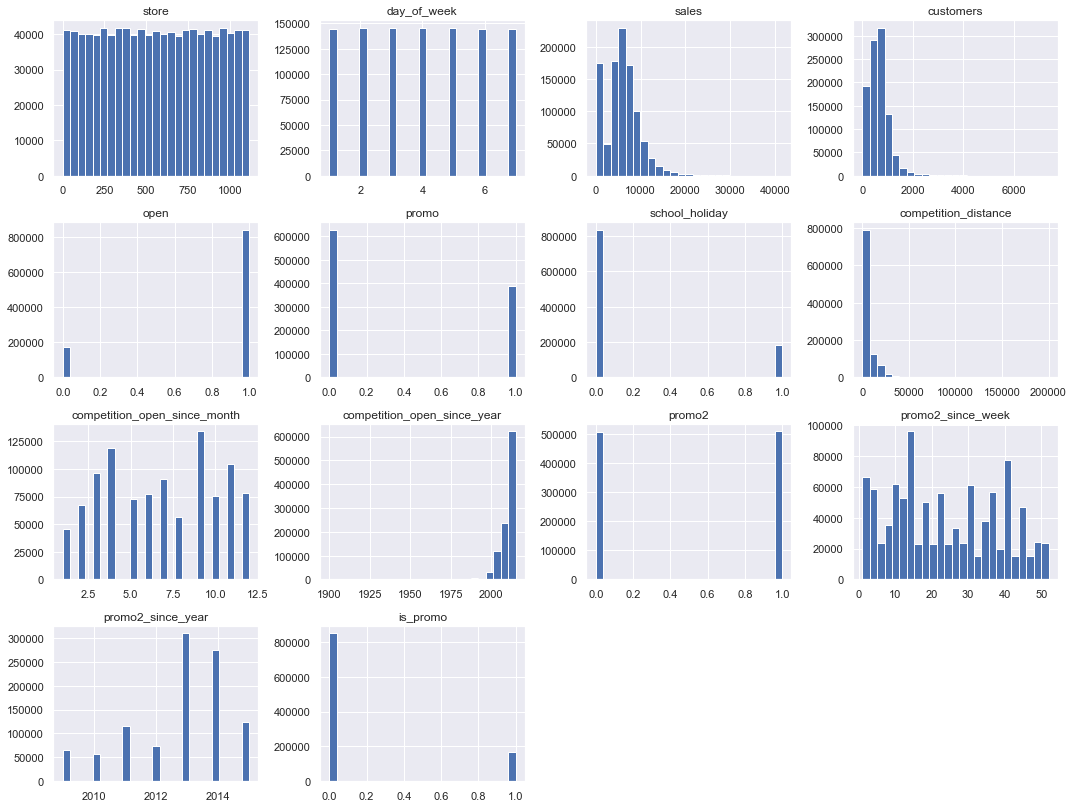

In [42]:
num_attributes.hist(bins=25, figsize = (18,14));
plt.show()

### 4.1.3. CATEGORICAL VARIABLE

In [43]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [40]:
df4['state_holiday'].drop_duplicates()

0             regular_day
54837      public holiday
107995    eastern_holiday
199792         christimas
Name: state_holiday, dtype: object

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


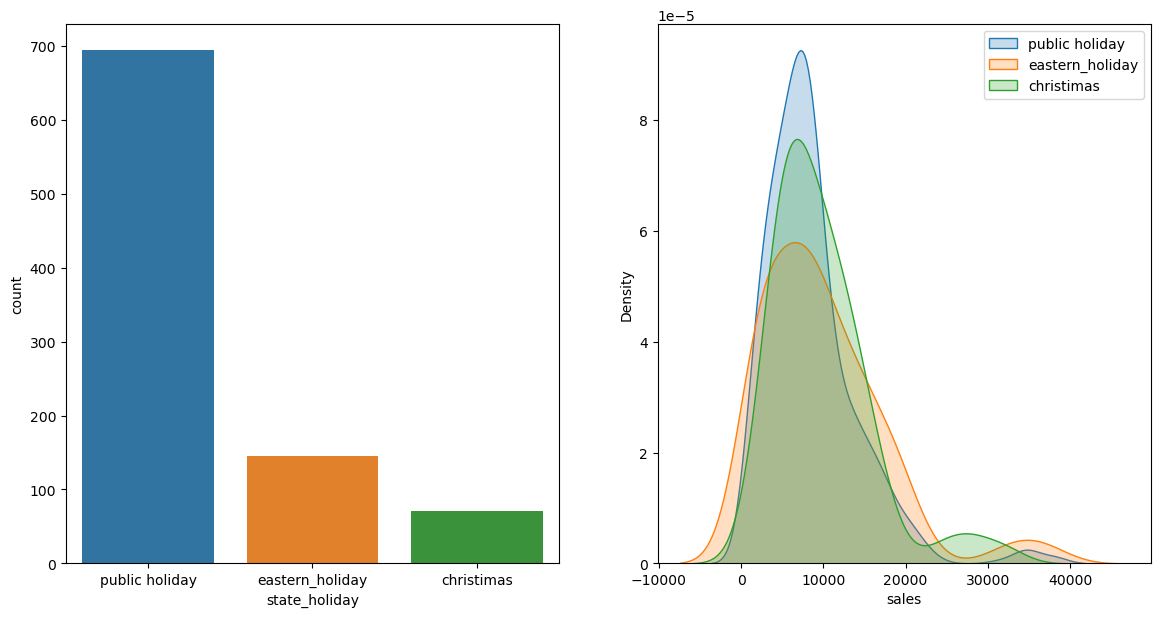

In [37]:
#state_holiday
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public holiday']['sales'], label='public holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'eastern_holiday']['sales'], label='eastern_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christimas']['sales'], label='christimas', shade=True)
plt.legend()
plt.show()

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


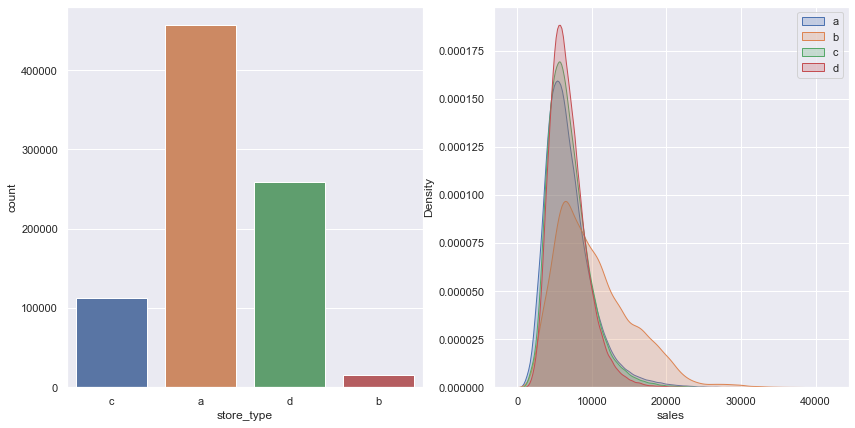

In [46]:
#store_type
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.countplot(df4['store_type'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()
plt.show()

C:\Users\kaotc\anaconda3\envs\DSemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


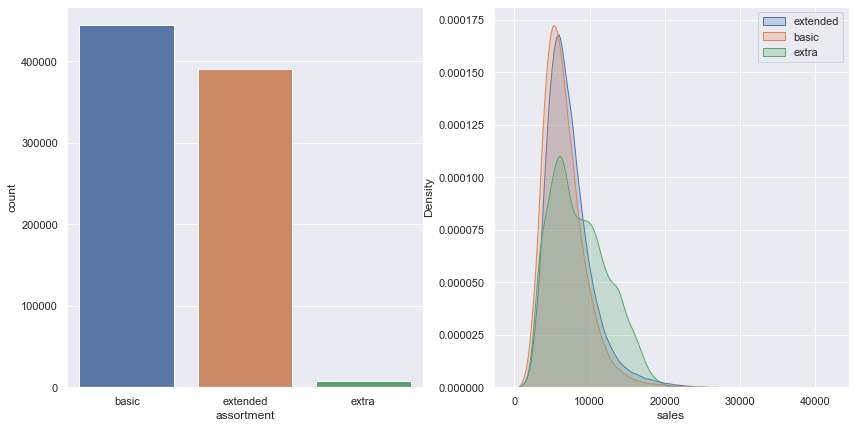

In [47]:
#assortment
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.countplot(df4['assortment'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()
plt.show()

## 4.2. ANÁLISE BIVARIADA

#### **H1.** Lojas com maior sortimento deveriam vender mais. - ASSORTMENT x SALES

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

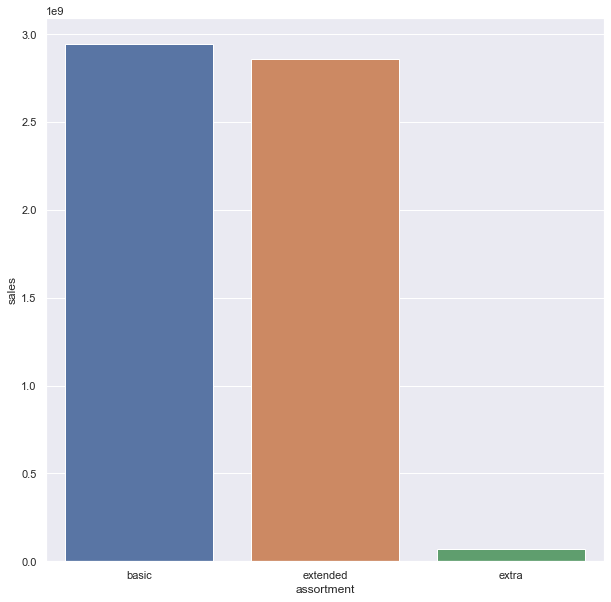

In [48]:
plt.figure(figsize=(10, 10))
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

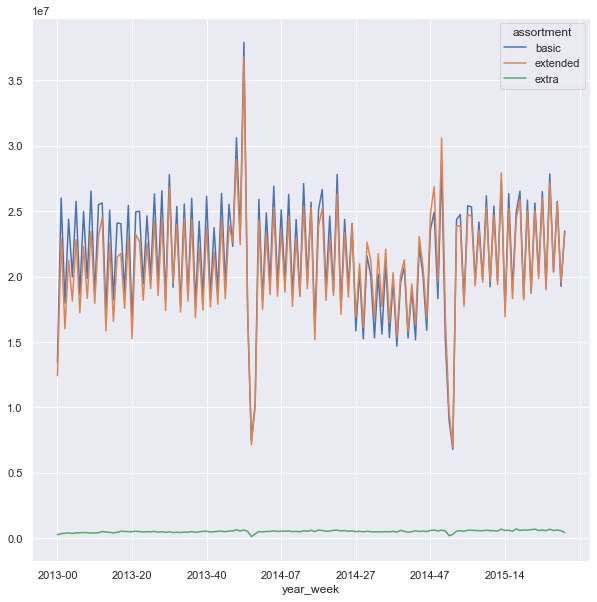

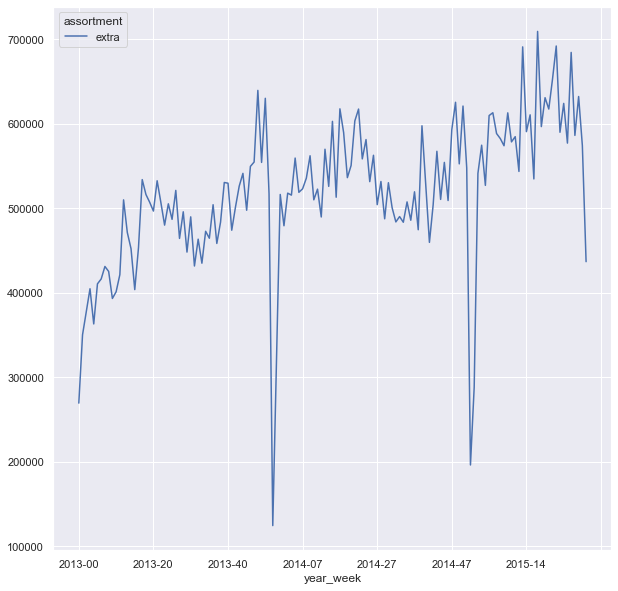

In [49]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize = (10,10))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize = (10,10))
plt.show()

#### **H2.** Lojas com competidores mais próximos deveriam vender menos - COMPETITION DISTANCE x SALES

**FALSA** Lojas com competidores MAIS PRÓXIMOS vendem MAIS.

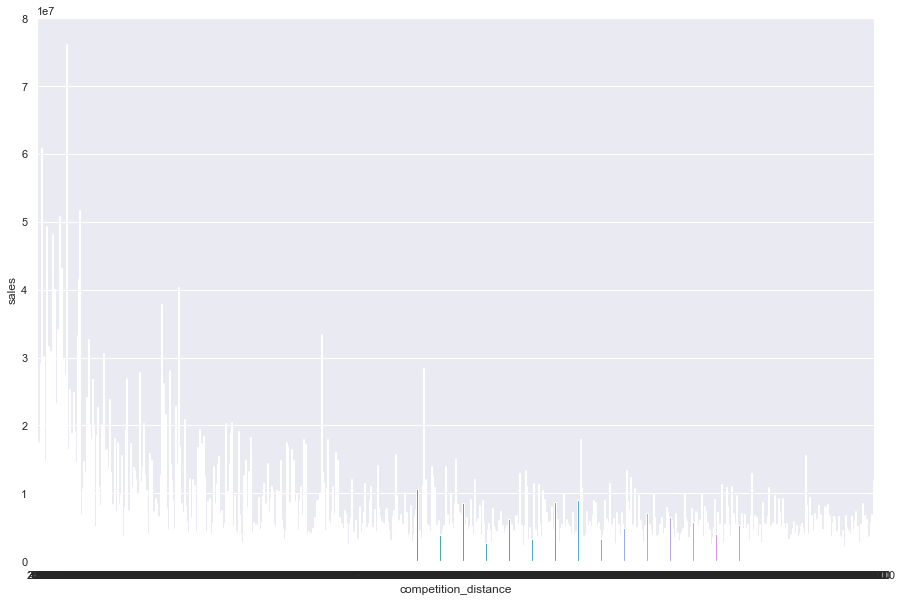

In [50]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(15, 10))
sns.barplot(x='competition_distance', y='sales', data=aux1);
plt.show()

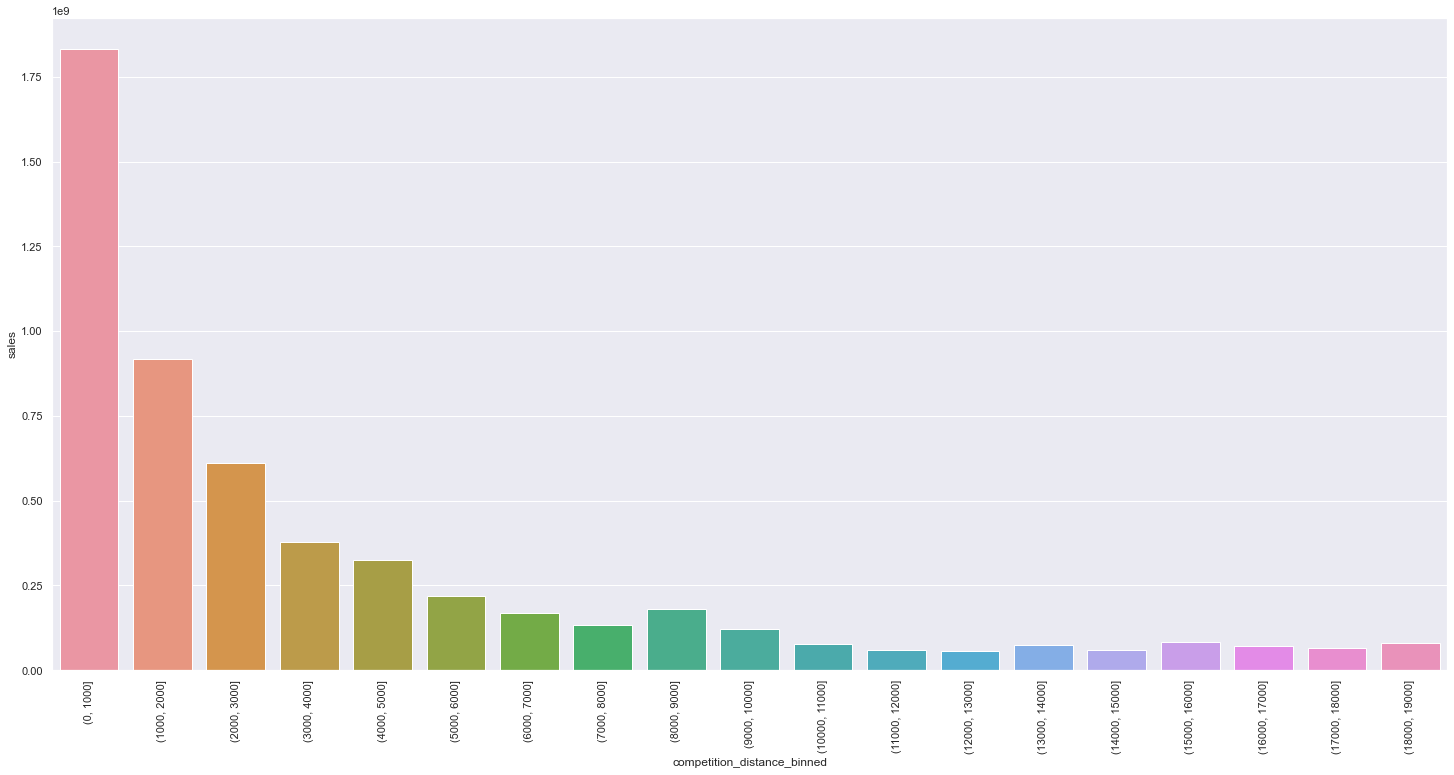

In [51]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.figure(figsize=(25, 12))
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);
plt.show()

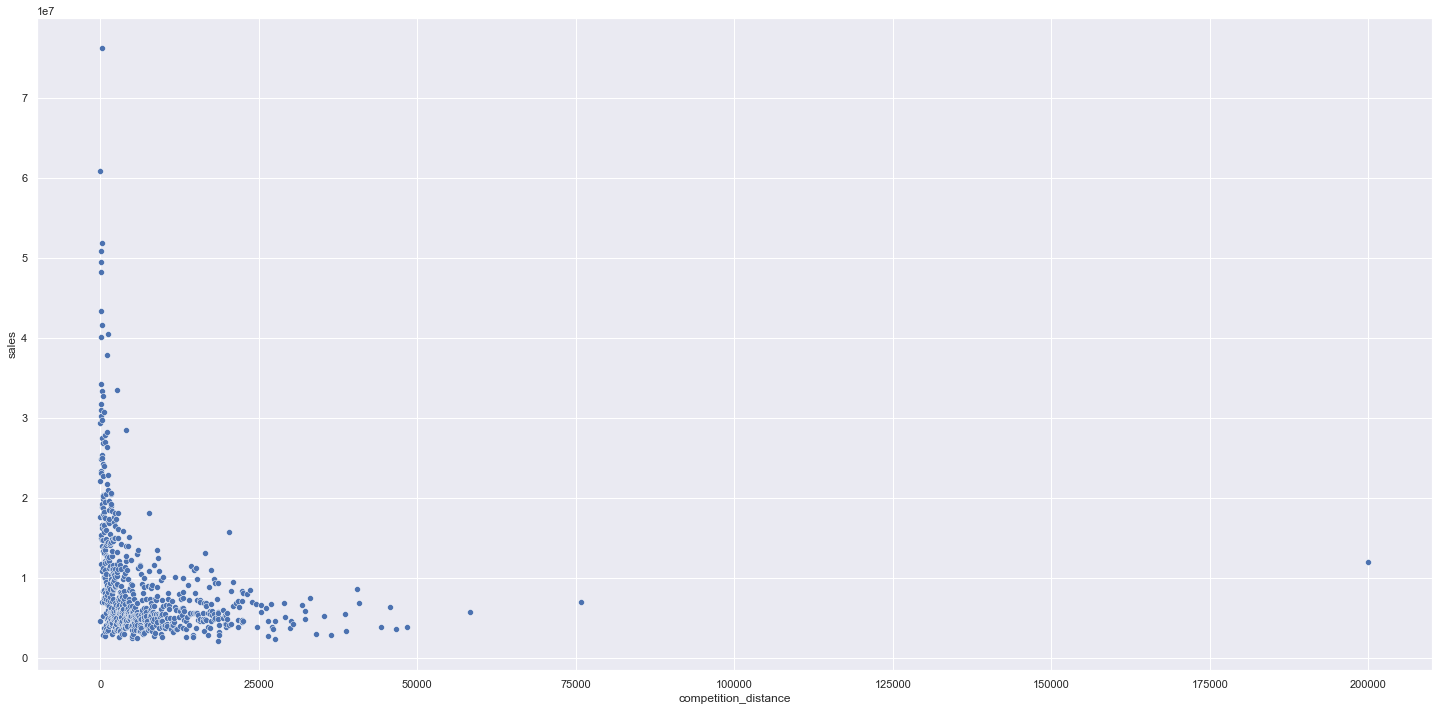

In [52]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(25, 12))
sns.scatterplot(x='competition_distance', y='sales', data=aux1);
plt.show()

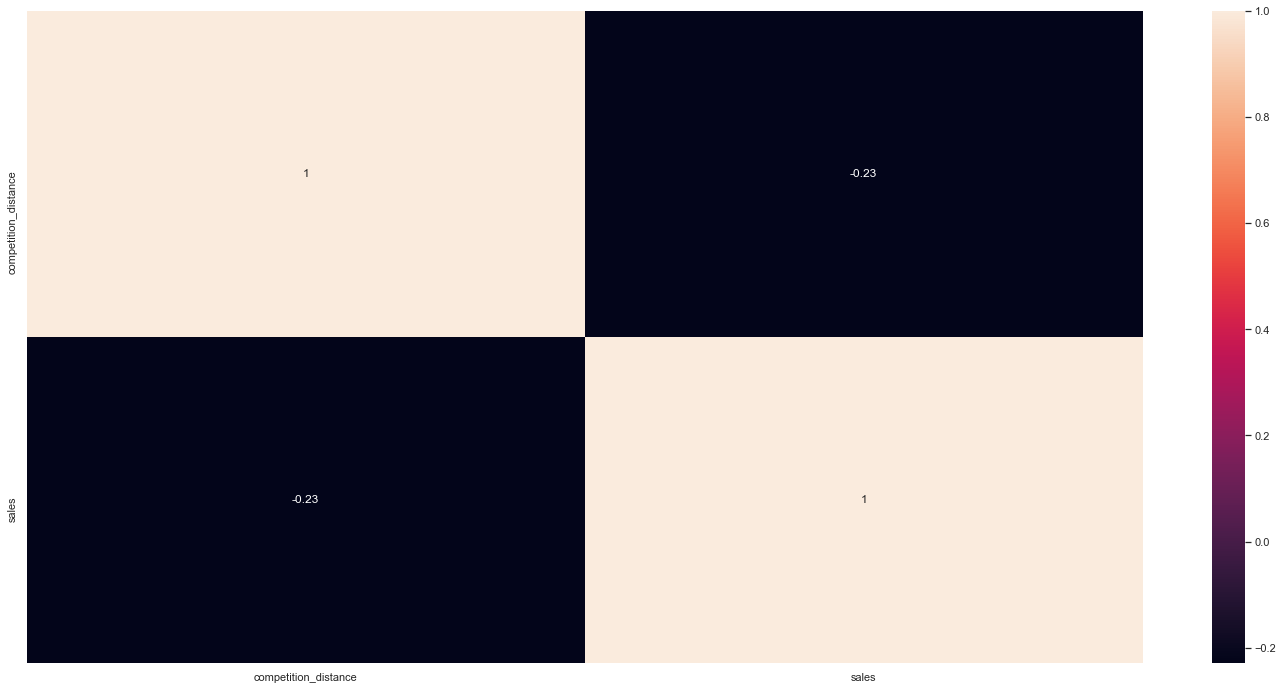

In [53]:
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.show()

#### **H3.** Lojas com competidores à mais tempo deveriam vender mais. COMPETITION TIME MONTH x SALES

**FALSA** Lojas com competidores à mais tempo vendem MENOS.

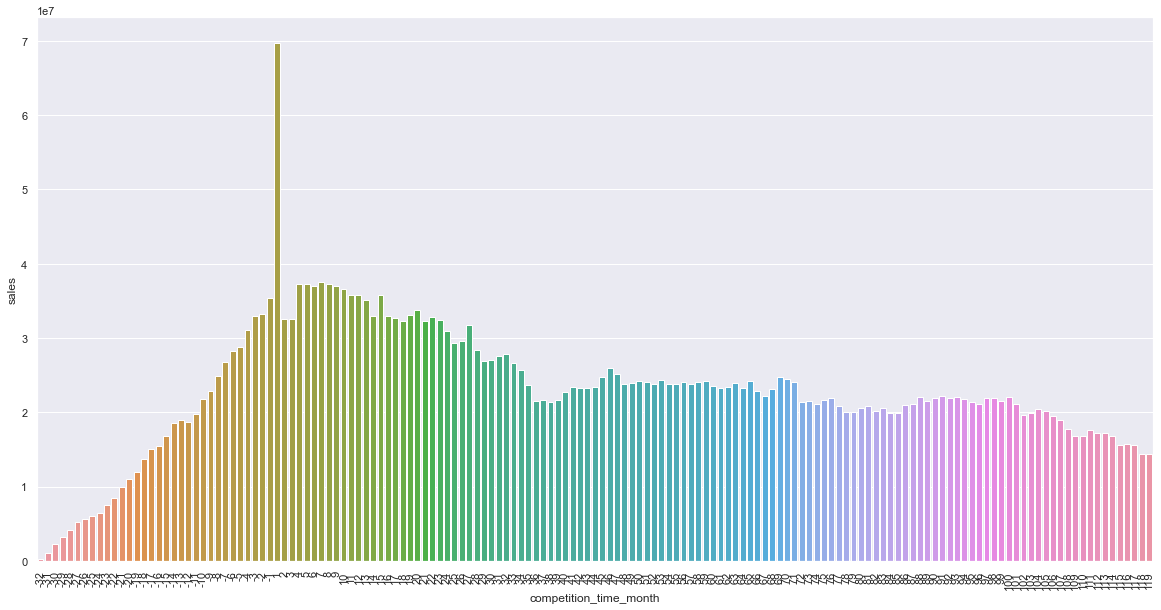

In [54]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]
plt.figure(figsize=(20, 10))
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);
plt.show()

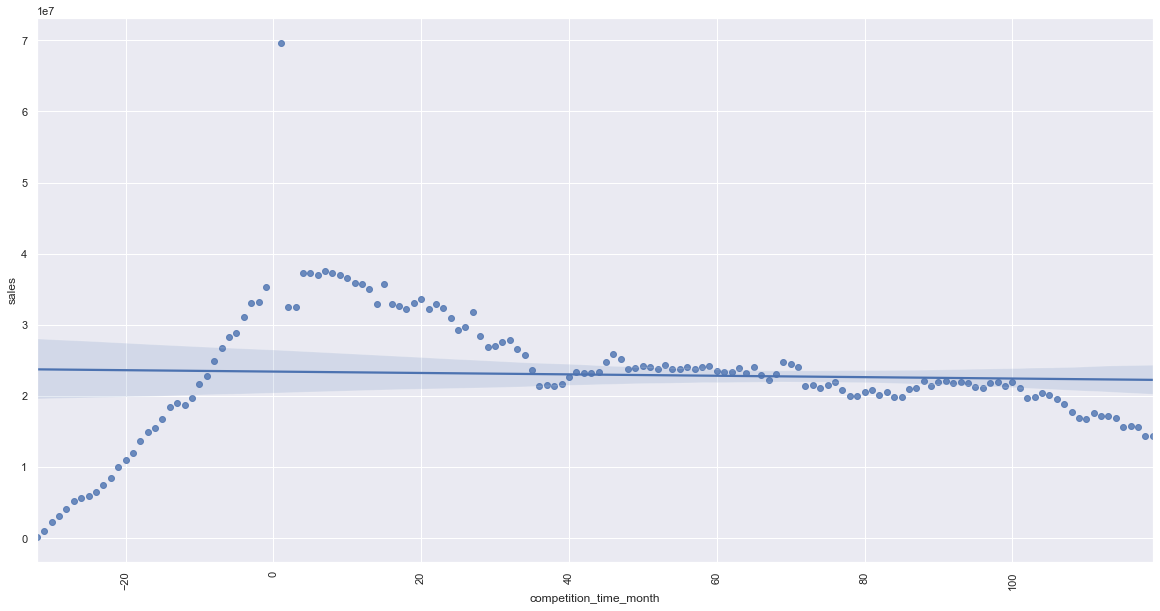

In [55]:
plt.figure(figsize=(20, 10))
sns.regplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);
plt.show()

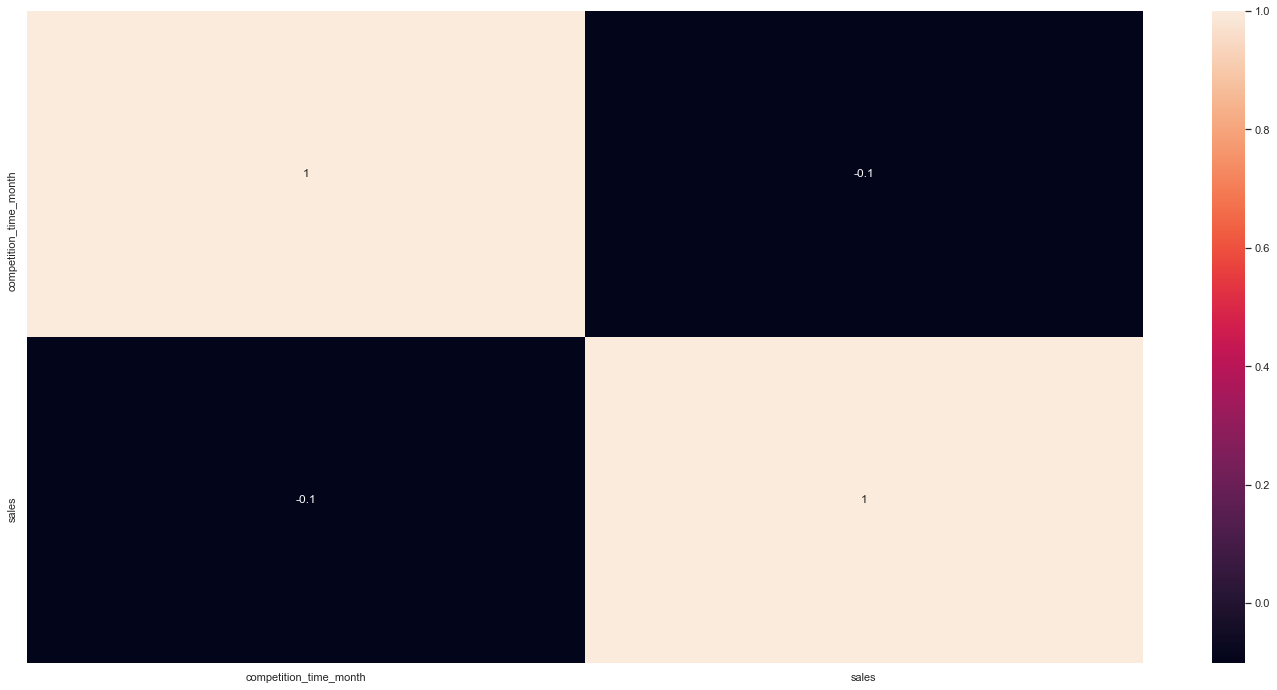

In [56]:
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

#### **H4.** Lojas com promoções ativas por mais tempo deveria vender mais. PROMO TIME WEEK x SALES

**FALSA**  Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

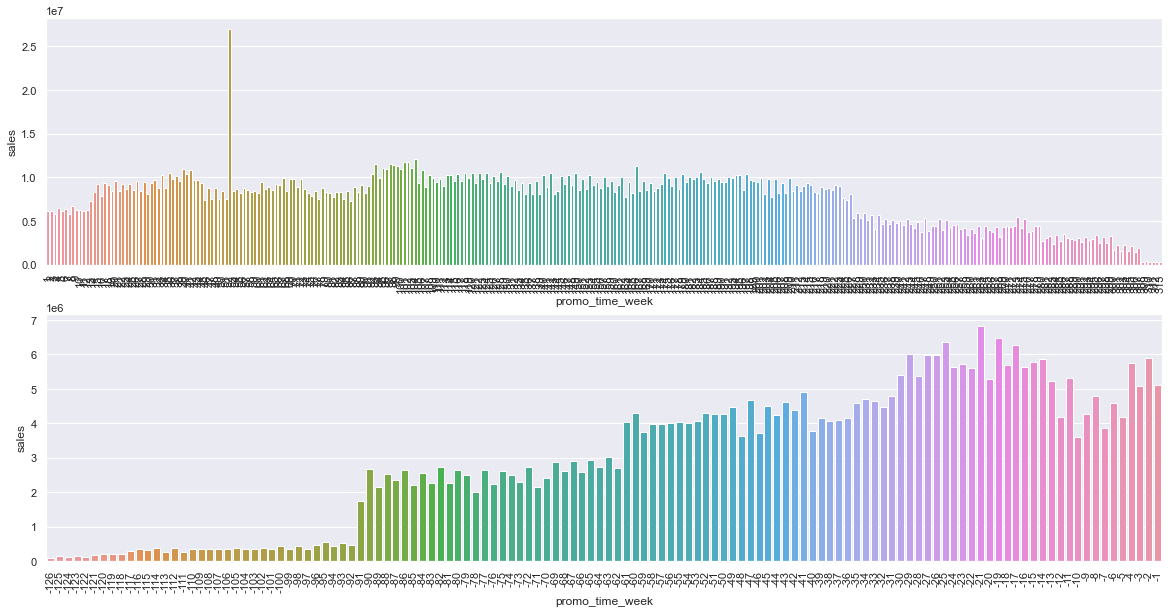

In [57]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
plt.figure(figsize=(20, 10))
sns.barplot(x='promo_time_week', y='sales', data=aux1);

plt.subplot(2, 1, 1)
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(2, 1, 2)
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);
plt.show()

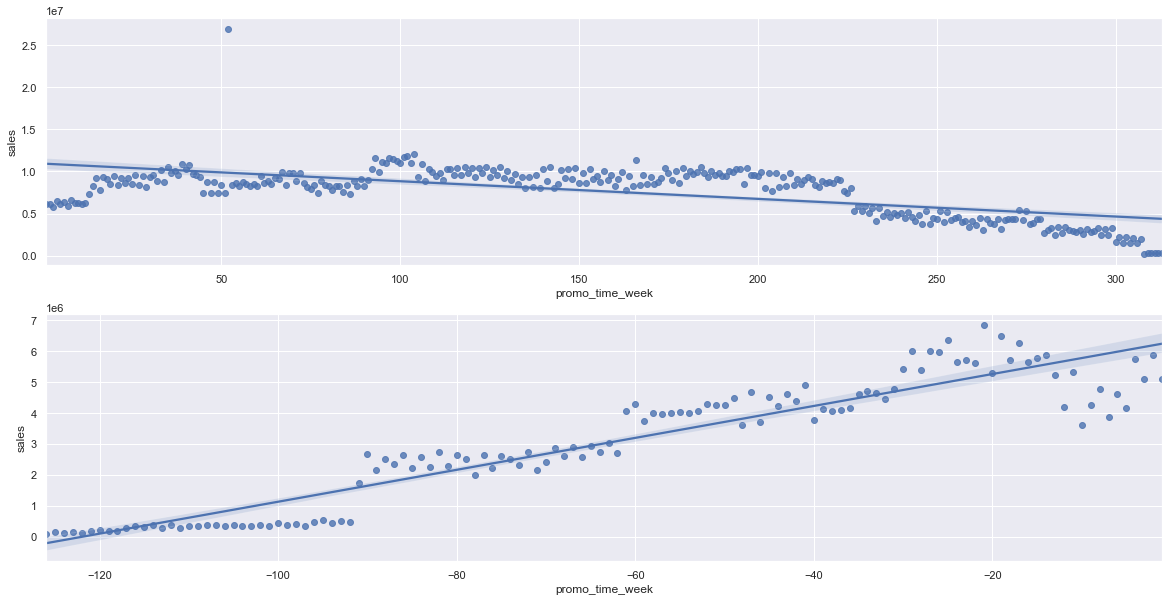

In [58]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(2, 1, 2)
sns.regplot(x='promo_time_week', y='sales', data=aux3);
plt.show()

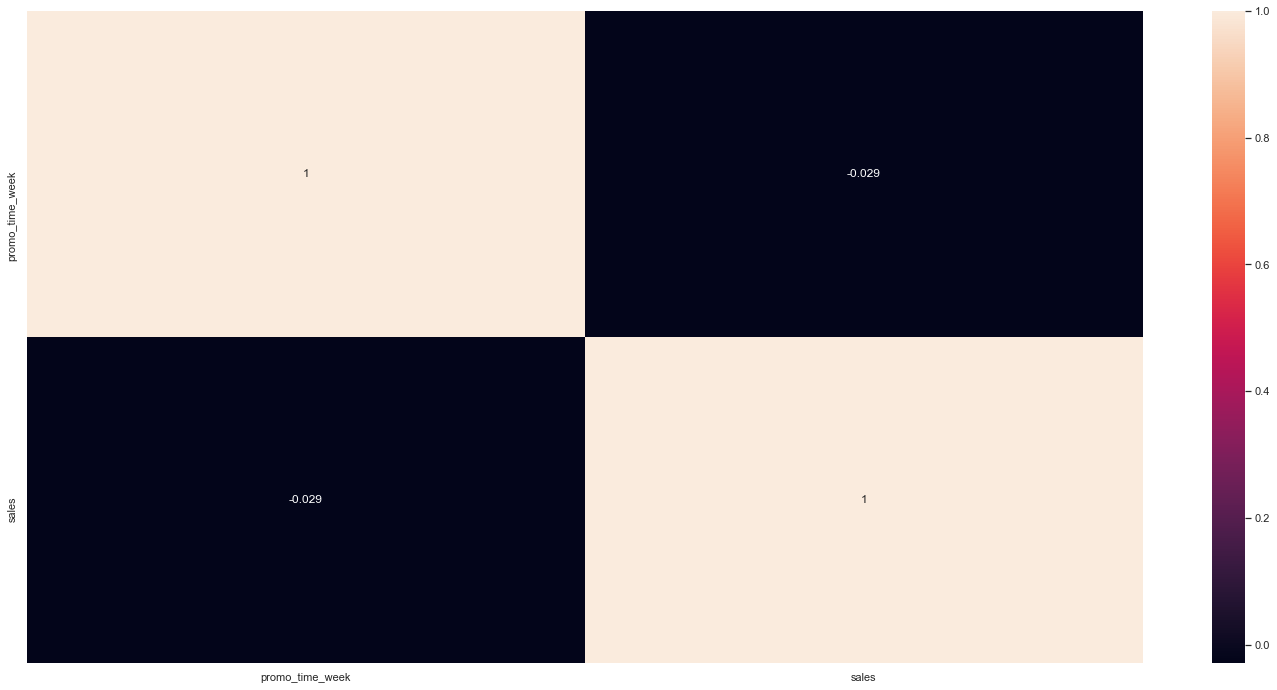

In [59]:
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.show()

#### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais. PROMO + PROMO 2 x SALES

**FALSA** Lojas com mais promoções consecutivas vendem menos

In [60]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


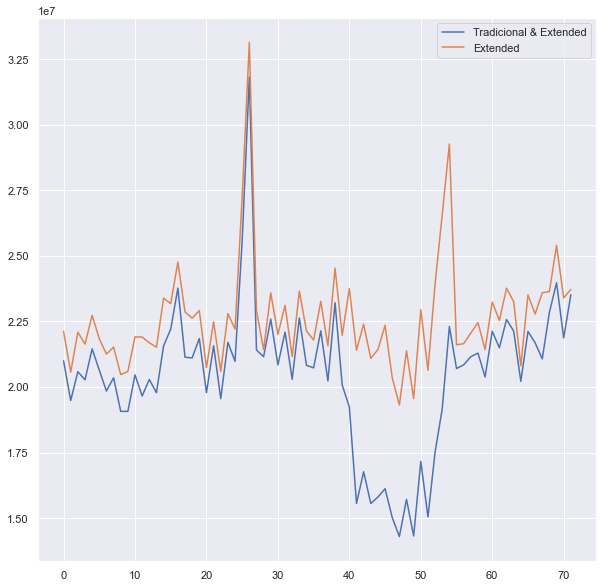

In [61]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize = (10,10))

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax, figsize = (10,10))
ax.legend(labels=['Tradicional & Extended', 'Extended'])
plt.show()

#### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA** Lojas abertas durante o feriado de natal vendem MENOS.

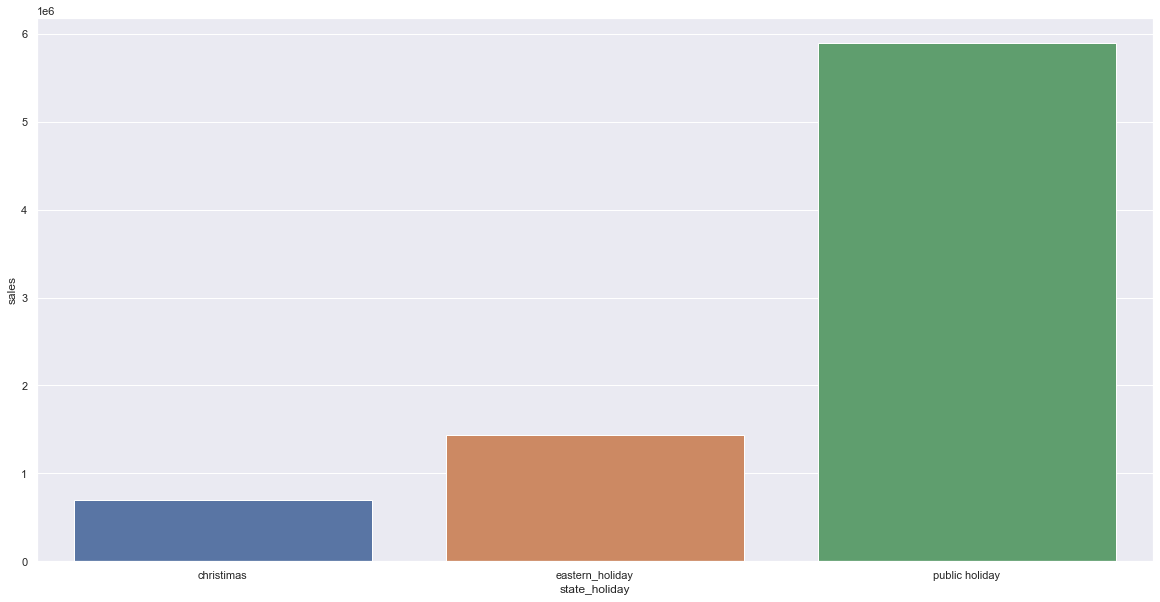

In [62]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.figure(figsize=(20, 10))
sns.barplot(x='state_holiday', y='sales', data=aux1);
plt.show()

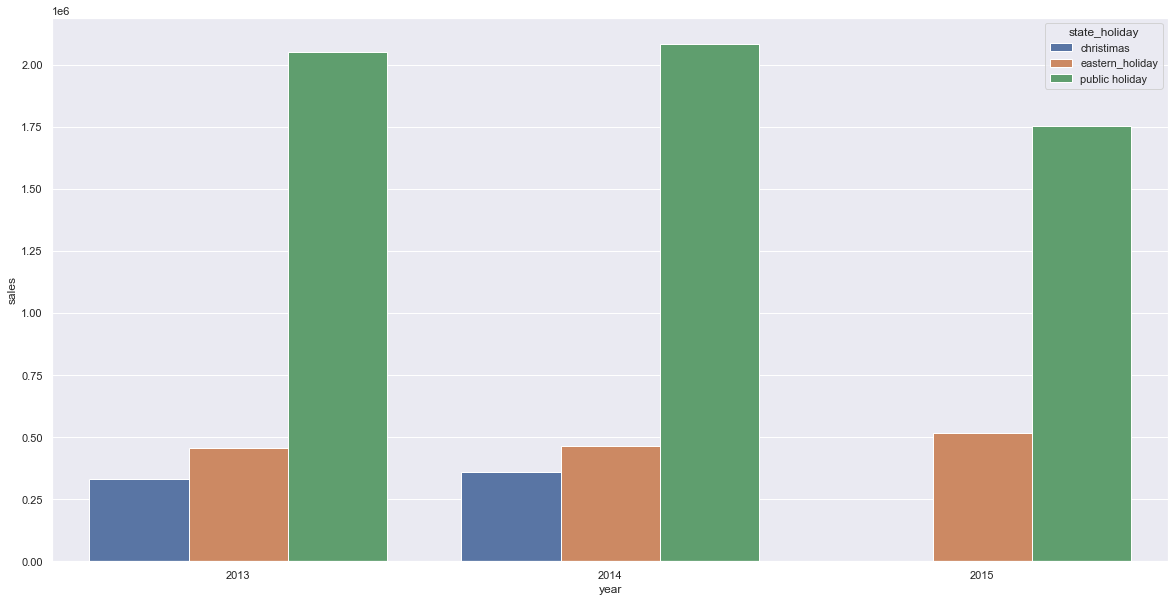

In [63]:
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.figure(figsize=(20, 10))
sns.barplot(x='year', y='sales', hue='state_holiday',data=aux2);
plt.show()

#### **H8.** Lojas deveriam vender mais ao longo dos anos.

**FALSA** Lojas vendem MENOS ao longo dos anos.

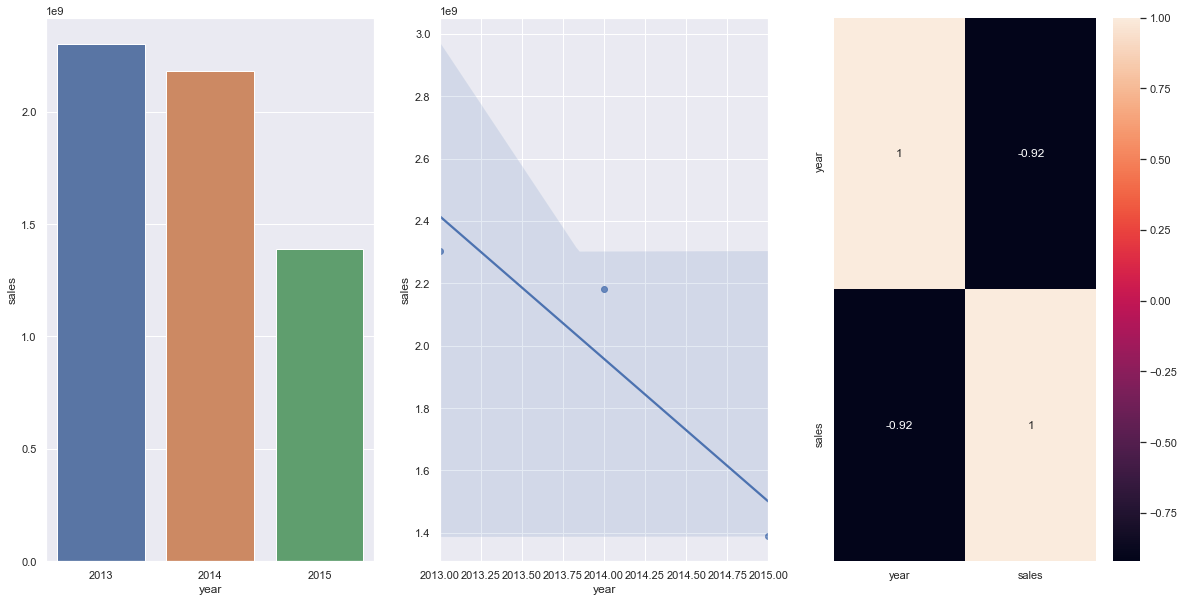

In [64]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.show()

#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.

**FALSA** Lojas vendem MENOS no segundo semestre do ano.

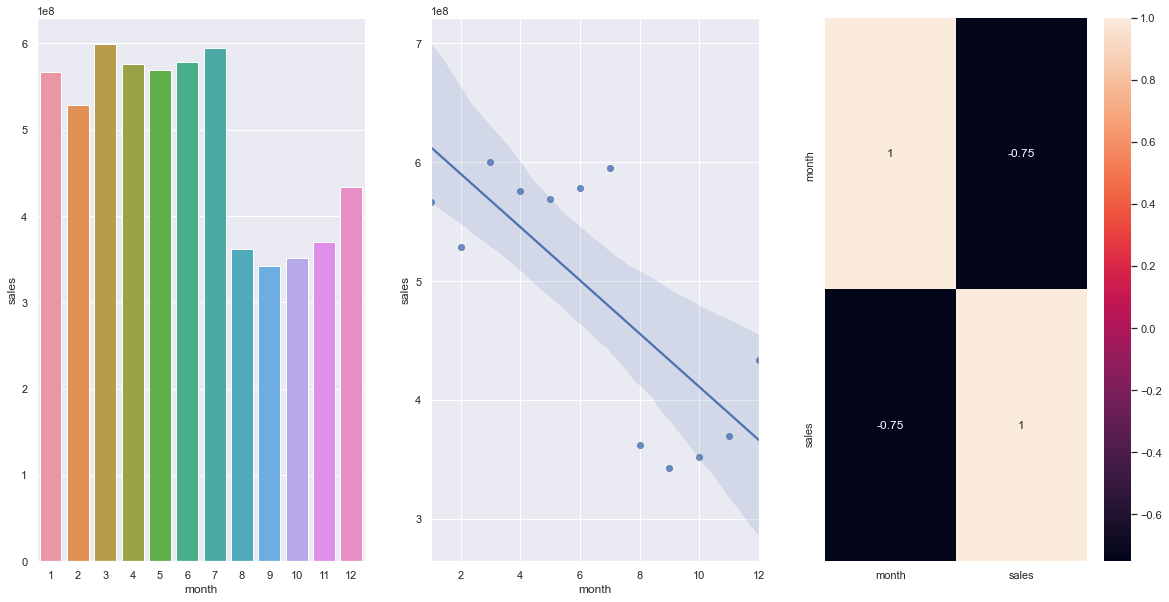

In [65]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.show()

#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

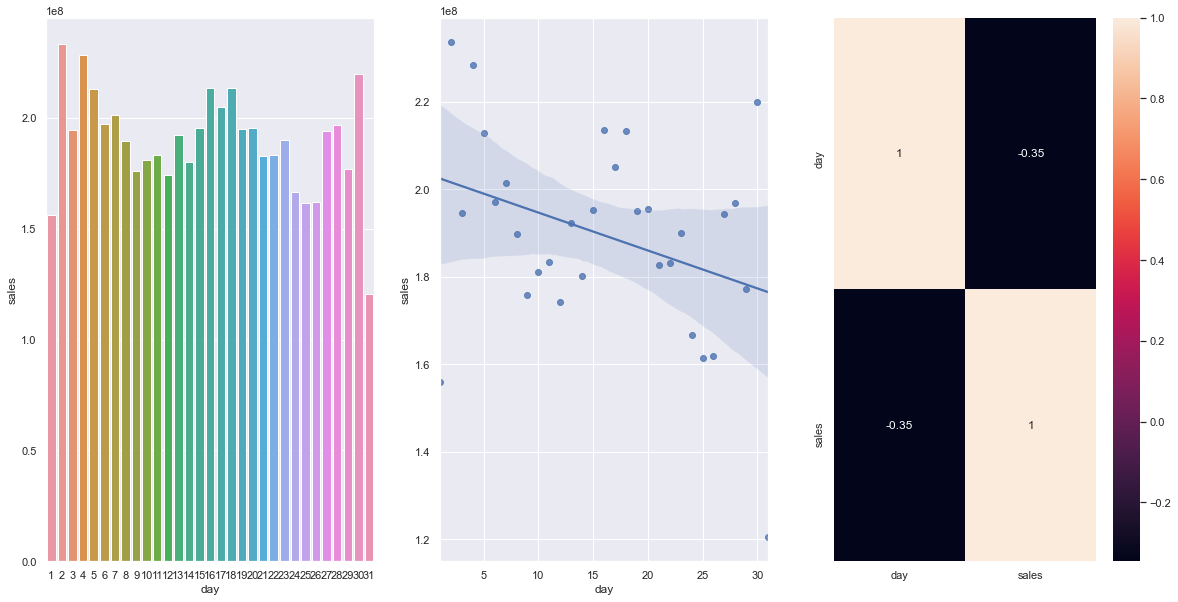

In [66]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.show()

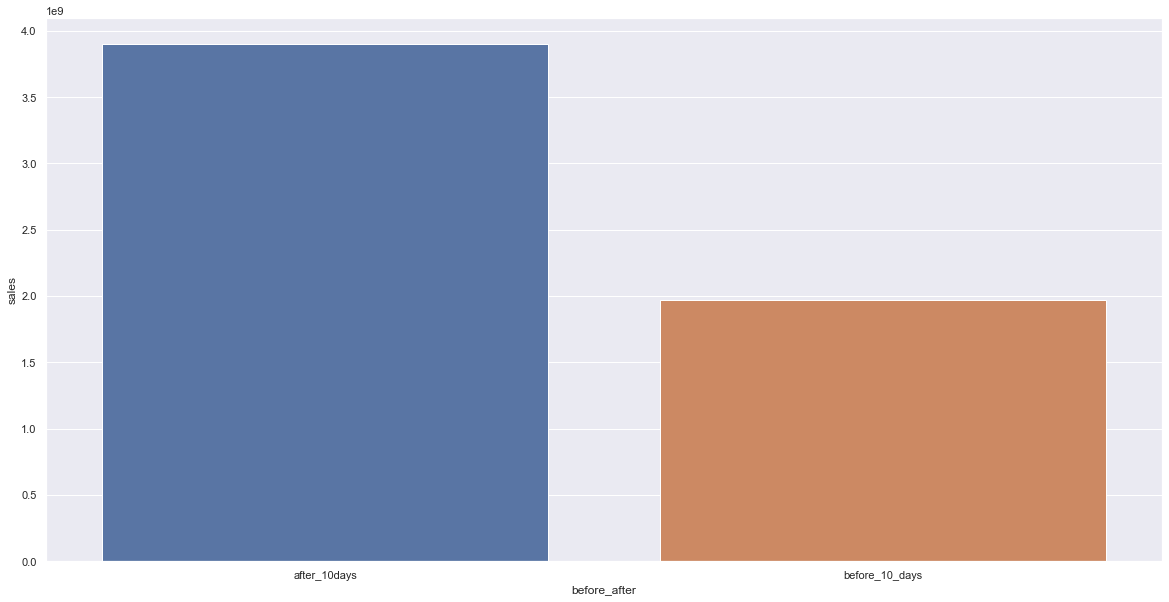

In [67]:
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
plt.figure(figsize=(20, 10))
sns.barplot(x='before_after', y='sales', data=aux2);
plt.show()

#### **H11.** Lojas deveriam vender menos nos finais de semana.

**VERDADEIRA** Lojas vendem menos nos finais de semana.

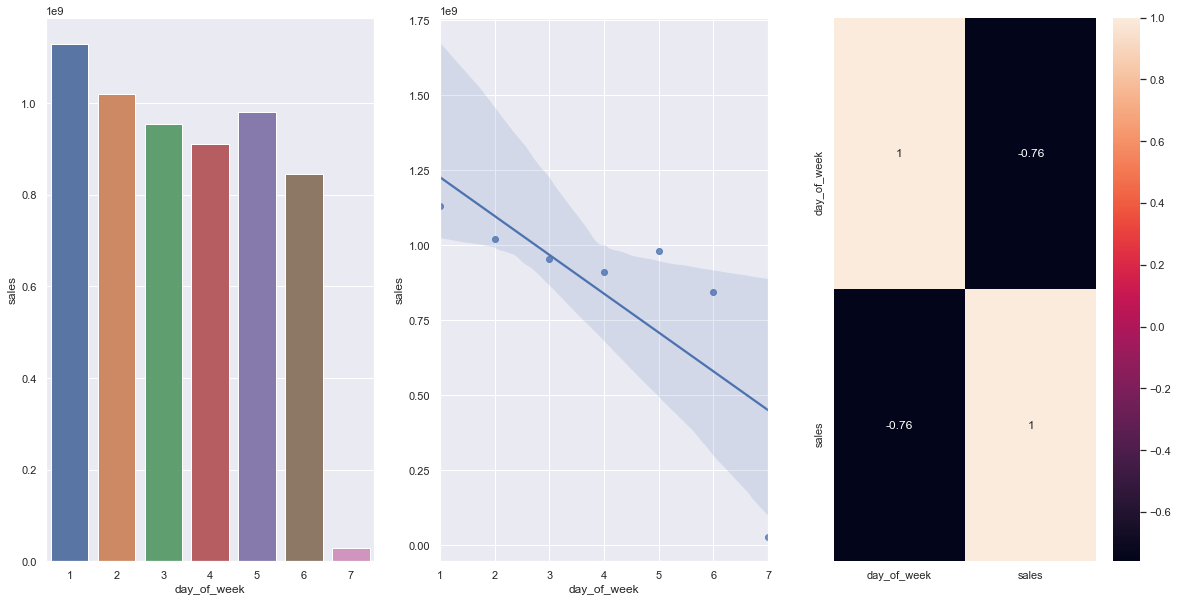

In [68]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.show()

#### **H12.** Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

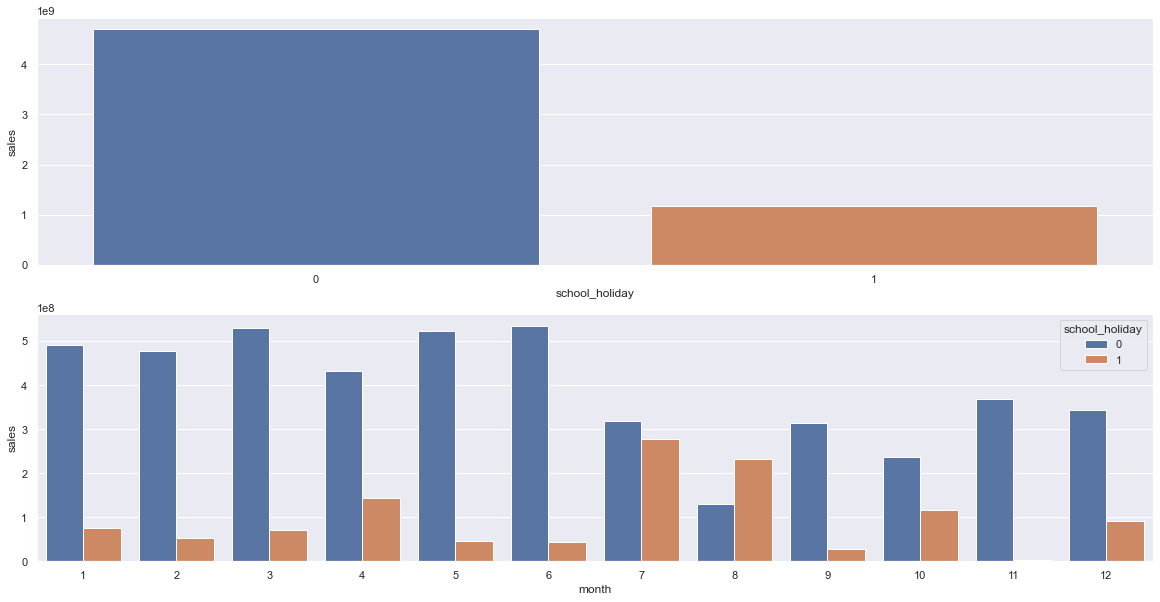

In [69]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday',data=aux2)
plt.show()

### 4.2.1 RESUMO DAS HIPÓTESES

In [70]:
from tabulate import tabulate

In [71]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Média'], 
      ['H3', 'Falsa', 'Média'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'], 
      ['H7', 'Falsa', 'Média'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. ANÁLISE MULTIVARIADA

### 4.3.1. NUMERICAL ATTIBUTES

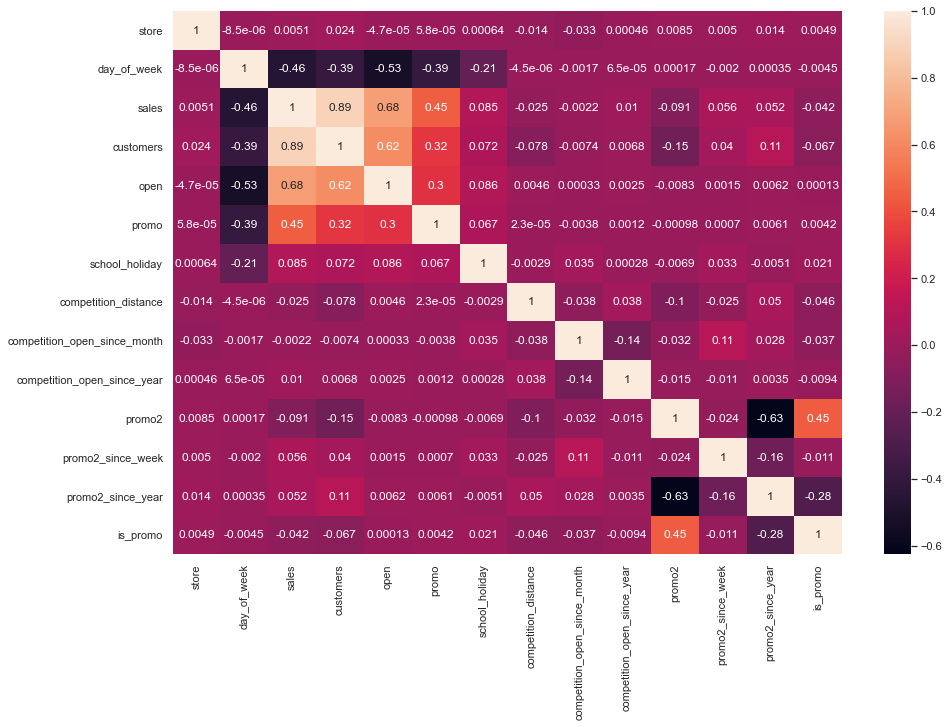

In [72]:
correlation = num_attributes.corr(method ='pearson')
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True)
plt.show()

### 4.3.2. CATEGORICAL ATTRIBUTES

In [73]:
a = df4.select_dtypes(include='object')
a.head()

,date,state_holiday,store_type,assortment,year_week,competition_since,promo_since
0,2015-07-31,regular_day,c,basic,2015-30,2008-09-01,2015-07-27
1,2015-07-31,regular_day,a,basic,2015-30,2007-11-01,2010-03-22
2,2015-07-31,regular_day,a,basic,2015-30,2006-12-01,2011-03-28
3,2015-07-31,regular_day,c,extended,2015-30,2009-09-01,2015-07-27
4,2015-07-31,regular_day,a,basic,2015-30,2015-04-01,2015-07-27


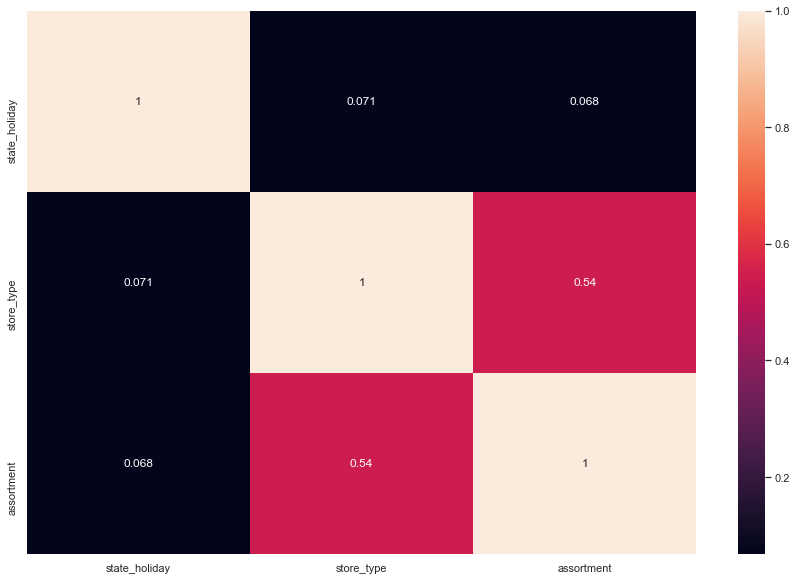

In [74]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday' : [a1, a2, a3],
             'store_type' : [a4, a5, a6],
             'assortment' : [a7, a8, a9]
             })
d = d.set_index(d.columns)
plt.figure(figsize=(15, 10))
sns.heatmap(d, annot=True)
plt.show()

In [75]:
df4.to_csv('dataset/C1/c01_04_rossman.csv', index=False)

# 5.0 DATA PREPARATION

In [3]:
df5 = pd.read_csv('dataset/C1/c01_04_rossman.csv')

## 5.1. NORMALIZAÇÃO

In [ ]:
# Não temos variáveis potenciais para normalização.

In [77]:
num_attributes = df5.select_dtypes(include=('int64', 'float64'))
cat_attributes = df5.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))
num_attributes.to_csv('stores_sales_num.csv', index=False)

In [78]:
num_attributes.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


## 5.2. RESCALLING

In [79]:
a = df5.select_dtypes(include=['int64', 'float64'])
a.describe().T

,count,mean,std,min,25%,50%,75%,max
store,844338.0,558.421374,321.730861,1.0,280.0,558.0,837.0,1115.0
day_of_week,844338.0,3.520350,1.723712,1.0,2.0,3.0,5.0,7.0
sales,844338.0,6955.959134,3103.815515,46.0,4859.0,6369.0,8360.0,41551.0
promo,844338.0,0.446356,0.497114,0.0,0.0,0.0,1.0,1.0
school_holiday,844338.0,0.193578,0.395102,0.0,0.0,0.0,0.0,1.0
competition_distance,844338.0,5961.827515,12592.181107,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,844338.0,6.787355,3.309917,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,844338.0,2010.331102,5.502628,1900.0,2008.0,2012.0,2014.0,2015.0
promo2,844338.0,0.498670,0.499999,0.0,0.0,0.0,1.0,1.0
promo2_since_week,844338.0,23.629083,14.288315,1.0,12.0,22.0,37.0,52.0


In [80]:
rs = RobustScaler(unit_variance=False)
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))
        
#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

In [81]:
a = df5.select_dtypes(include=['int64', 'float64'])
a.describe().T

,count,mean,std,min,25%,50%,75%,max
store,844338.0,558.421374,321.730861,1.000000,280.000000,558.000000,837.000000,1115.000000
day_of_week,844338.0,3.520350,1.723712,1.000000,2.000000,3.000000,5.000000,7.000000
sales,844338.0,6955.959134,3103.815515,46.000000,4859.000000,6369.000000,8360.000000,41551.000000
promo,844338.0,0.446356,0.497114,0.000000,0.000000,0.000000,1.000000,1.000000
school_holiday,844338.0,0.193578,0.395102,0.000000,0.000000,0.000000,0.000000,1.000000
competition_distance,844338.0,0.585779,2.030997,-0.372581,-0.261290,0.000000,0.738710,31.882258
competition_open_since_month,844338.0,6.787355,3.309917,1.000000,4.000000,7.000000,10.000000,12.000000
competition_open_since_year,844338.0,2010.331102,5.502628,1900.000000,2008.000000,2012.000000,2014.000000,2015.000000
promo2,844338.0,0.498670,0.499999,0.000000,0.000000,0.000000,1.000000,1.000000
promo2_since_week,844338.0,23.629083,14.288315,1.000000,12.000000,22.000000,37.000000,52.000000


## 5.3. TRANSFORMAÇÃO

### 5.3.1 ENCODING

In [82]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

#assortment - Oridinal Encoding
assortment_dict = {'basic': 1, 'extra' : 2, 'extended' : 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. RESPONSE VARIABLE TRANSFORMATION

In [83]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2. NATURE TRANSFORMATION

In [84]:
#day of the week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))
#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

In [85]:
df5.to_csv('dataset/C1/c01_05_rossman.csv', index=False)

# 6.0 FEATURE SELECTION

In [3]:
df6 = pd.read_csv('dataset/C1/c01_05_rossman.csv')

In [4]:
df6['date'] = pd.to_datetime(df6['date'])
df6.dtypes

store                                     int64
day_of_week                               int64
date                             datetime64[ns]
sales                                   float64
promo                                     int64
school_holiday                            int64
store_type                                int64
assortment                                int64
competition_distance                    float64
competition_open_since_month              int64
competition_open_since_year               int64
promo2                                    int64
promo2_since_week                         int64
promo2_since_year                         int64
is_promo                                  int64
year                                    float64
month                                     int64
day                                       int64
week_of_year                              int64
year_week                                object
competition_since                       

## 6.1. SPLIT DATAFRAME INTO TRAINING AND TEST DATASET

In [5]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [7]:
# não mostrar ao algoritmo as vendas do futuro
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [6]:
#Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. BORUTA AS FEATURE SELECTOR

In [93]:
X_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christimas,state_holiday_eastern_holiday,state_holiday_public holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
41396,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.891892,0.287016,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
41397,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,1.027027,0.908884,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
41398,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,1.189189,0.788155,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
41399,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,0.729730,0.287016,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
41400,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,-0.189189,0.287016,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709


In [94]:
##training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel() #ravel coverter em vetor
#
##define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
##define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.1. BEST FEATURES FROM BORUTA

In [95]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop(['date','sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [96]:
#cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [97]:
#cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christimas',
 'state_holiday_eastern_holiday',
 'state_holiday_public holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3. MANUAL FEATURE SELECTION

In [7]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales'] #será adicionado posteriormente (no módulo seguinte ele voltou a adicionar conforme abaixo)

#final features
#cols_selected_boruta.extend(feat_to_add)

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [10]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 MACHINE LEARNING MODELLING

In [11]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 AVERAGE MODEL

In [101]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predicitions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predicitions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 LINEAR REGRESSION MODEL

In [102]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result
# RMSE - erro de regressão linear é maior (o comportamento não é linear)

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. LINEAR REGRESSION MODEL - CROSS VALIDATION

In [103]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 7.3 LINEAR REGRESSION REGULARIZED MODEL - LASSO

In [104]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. LINEAR REGRESSION REGULARIZED MODEL - LASSO - CROSS VALIDATION

In [105]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## 7.4. RANDOM FOREST REGRESSOR

In [106]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.376406,0.099795,1009.129868


### 7.4.1. RANDOM FOREST REGRESSOR - CROSS VALIDATION

In [107]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, True)
rf_result_cv


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.47+/-217.71,0.12+/-0.02,1256.28+/-317.63


## 7.5. XGBOOST REGRESSOR

In [108]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            #colsample_bytee=0.9,
                            ).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6064,0.949503,7330.742181


### 7.5.1. XGBOOST REGRESSOR - CROSS VALIDATION

In [109]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, True)
xgb_result_cv


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.94+/-587.64,0.95+/-0.0,7714.0+/-688.71


## 7.6 COMPARE MODEL´S PERFORMANCE

### 7.6.1 SINGLE PERFORMANCE

In [110]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.376406,0.099795,1009.129868
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.606400,0.949503,7330.742181


### 7.6.2 REAL PERFORMANCE - CROSS VALIDATION

In [111]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.47+/-217.71,0.12+/-0.02,1256.28+/-317.63
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Linear Regression - Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,XGBoost Regressor,7047.94+/-587.64,0.95+/-0.0,7714.0+/-688.71


# 8.0 HYPERPARAMETER FINE TUNNING

## 8.1. RANDOM SEARCH

In [14]:
param = {#'n_estimators': [15, 17, 25, 30, 35],
         #'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytee': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5
#modelo demora muito, mas os n_estimators * 100

In [15]:
final_result =  pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    warnings.filterwarnings('ignore')
    hp = {k : random.choice(v) for k, v in param.items()}
    print(hp)
    #model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                #n_estimators=hp['n_estimators'],
                                #eta=hp['eta'],
                                max_depth=hp['max_depth'],
                                subsample=hp['subsample'],
                                #colsample_bytee=hp['colsample_bytee'],
                                min_child_weight=hp['min_child_weight']                                                                               
                                ).fit(x_train, y_train)
    
    #prediction
    yhat_xgb = model_xgb.predict(x_test)
    
    #performance
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])

final_result

{'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 3}
{'max_depth': 9, 'subsample': 0.5, 'colsample_bytee': 0.9, 'min_child_weight': 15}
{'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 8}
{'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.7, 'min_child_weight': 15}
{'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 15}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1155.42+/-29.28,0.15+/-0.0,1685.41+/-69.92
0,XGBoost Regressor,900.77+/-125.11,0.12+/-0.01,1284.86+/-200.5
0,XGBoost Regressor,1605.55+/-42.02,0.22+/-0.0,2336.56+/-61.19
0,XGBoost Regressor,1174.3+/-47.83,0.16+/-0.0,1714.11+/-99.92
0,XGBoost Regressor,1615.34+/-57.98,0.22+/-0.0,2342.33+/-90.58


## 8.2 FINAL MODEL

In [59]:
param_tuned = {'n_estimators': 3000,
         'eta': 0.03,
         'max_depth': 5,
         'subsample': 0.7,
         'colsample_bytee': 0.7,
         'min_child_weight': 3
        }

In [139]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    #colsample_bytee=param_tuned['colsample_bytee'],
                                    min_child_weight=param_tuned['min_child_weight']                                                                               
                                    ).fit(x_train, y_train)
        
#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.058708,0.114528,1088.445567


In [176]:
x_test.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_cos,month_sin,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.568065,-0.822984
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.568065,-0.822984
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.568065,-0.822984
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.568065,-0.822984
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.568065,-0.822984


In [ ]:
#pickle.dump(model_xgb_tuned, open('model_rossmann.pkl', 'wb'))

In [140]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.01954354300527339

In [142]:
root_mean_squared_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

0.15749896263420293

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [143]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. BUSINESS PERFORMANCE

In [144]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,168659.87500,168355.883967,168963.866033,303.991033,0.070706
1,2,179762.93750,179304.091975,180221.783025,458.845525,0.092515
2,3,273038.90625,272291.307406,273786.505094,747.598844,0.103937
3,4,349240.65625,348474.542784,350006.769716,766.113466,0.073255
4,5,170626.68750,170293.461380,170959.913620,333.226120,0.077870


In [145]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106846.78125,103486.930253,110206.632247,3359.850997,0.588673
908,909,228641.00000,220905.138587,236376.861413,7735.861413,0.515674
169,170,207572.87500,206069.607937,209076.142063,1503.267063,0.372436
875,876,202657.40625,198713.378949,206601.433551,3944.027301,0.317065
594,595,370525.71875,366236.873654,374814.563846,4288.845096,0.295612


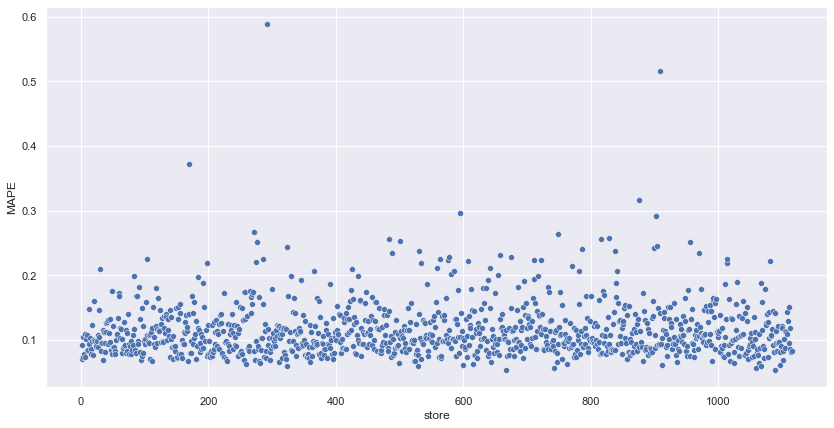

In [150]:
plt.figure(figsize=(14, 7))
sns.scatterplot(x='store', y='MAPE', data=df92)
plt.show()
# Relação Lojas vs o Erro MAPE

## 9.2. TOTAL PERFORMANCE

In [147]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenarios,Values
0,predictions,"R$287,260,608.00"
1,worst_scenario,"R$286,409,857.86"
2,best_scenario,"R$288,111,339.95"


## 9.3. MACHINE LEARNING PERFORMANCE

In [148]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

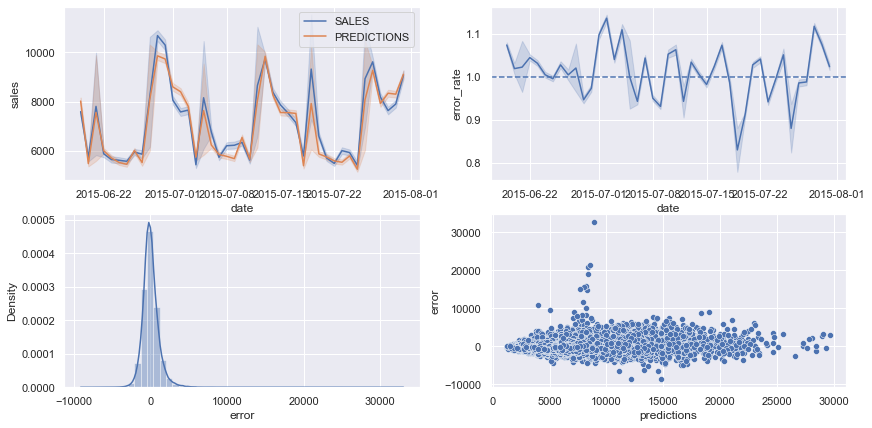

In [149]:
plt.figure(figsize=(14, 7))
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])
plt.show()

## 9.4 KAGGLE SUBMISSION

### 9.4.1. FUNCTIONS

In [11]:
def data_description(df):
    # storing columns names
    cols_old = ['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
           'SchoolHoliday']
    
    # transforming to underscore the names and put into lowcase
    snakecase = lambda x: inflection.underscore( x )
    
    # creating a list with a new snakecase columns name and indicating the new one
    cols_new = list( map( snakecase, cols_old ) )
    
    #renaming columns name
    df.columns = cols_new
    return df

In [86]:
def feature_engineering_preparation(df2):
    df2['date'] = pd.to_datetime(df2['date'])
    # year
    df2['year'] = df2['date'].dt.year
    # month
    df2['month'] = df2['date'].dt.month
    # day
    df2['day'] = df2['date'].dt.day
    # week of year
    df2['week_of_year'] = df2['date'].dt.isocalendar().week
    # year week
    df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
    
    # state holiday
    df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 1 if x=='a' else 0)
    
    mms = MinMaxScaler()
    df2['year'] = mms.fit_transform(df2[['year']].values)
    
    #day of the week
    df2['day_of_week_sin'] = df2['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
    df2['day_of_week_cos'] = df2['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))
    #month
    df2['month_sin'] = df2['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
    df2['month_cos'] = df2['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
    #day
    df2['day_sin'] = df2['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
    df2['day_cos'] = df2['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))
    #week of year
    df2['week_of_year_sin'] = df2['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
    df2['week_of_year_cos'] = df2['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))
    
    df2 = df2.drop(['id', 'open', 'day_of_week', 
                    'school_holiday', 'year', 'month', 'day', 
                    'week_of_year', 'year_week'], axis=1)
    df2 = df2[['store', 'promo', 'state_holiday', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'week_of_year_sin', 'week_of_year_cos']]
    return df2

### 9.4.2. KAGGLE TEST SET

In [88]:
df_test_kg = pd.read_csv('dataset/test.csv')

In [84]:
df2_kg.columns

Index(['store', 'date', 'promo', 'state_holiday', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'week_of_year_sin', 'week_of_year_cos'],
      dtype='object')

In [89]:
df1_kg = data_description(df_test_kg)
df2_kg = feature_engineering_preparation(df1_kg)
df2_kg.head()

,store,promo,state_holiday,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,1,0,-0.433884,-0.900969,-1.0,-1.836970e-16,-0.406737,-0.913545,-0.992709,-0.120537
1,3,1,0,-0.433884,-0.900969,-1.0,-1.836970e-16,-0.406737,-0.913545,-0.992709,-0.120537
2,7,1,0,-0.433884,-0.900969,-1.0,-1.836970e-16,-0.406737,-0.913545,-0.992709,-0.120537
3,8,1,0,-0.433884,-0.900969,-1.0,-1.836970e-16,-0.406737,-0.913545,-0.992709,-0.120537
4,9,1,0,-0.433884,-0.900969,-1.0,-1.836970e-16,-0.406737,-0.913545,-0.992709,-0.120537


### 4.4.3. TRANING DATA SET

In [63]:
df_to_kg = ['sales', 'date', 'store', 'promo', 'state_holiday', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos']

In [64]:
df_train_kg = df6.copy()
df_train_kg['state_holiday'] = df4['state_holiday']
map_holiday = {'regular_day': 0, 'public holiday': 1, 'eastern_holiday': 1, 'christimas': 1}
df_train_kg['state_holiday'] = df_train_kg['state_holiday'].map(map_holiday)
df_train_kg = df_train_kg.drop(['state_holiday_christimas',
                                'state_holiday_eastern_holiday',
                                'state_holiday_public holiday',
                                'state_holiday_regular_day',
                                'school_holiday', 'store_type', 'assortment',
                                'competition_distance', 'competition_open_since_month', 
                                'competition_open_since_year', 'competition_time_month',
                                'promo2', 'promo2_since_week', 'promo2_since_year', 'is_promo', 'promo_time_week'
                               ], axis=1)
df_train_kg = df_train_kg[df_to_kg]
df_train_kg.head()

,sales,date,store,promo,state_holiday,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,8.568646,2015-07-31,1,1,0,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,8.710290,2015-07-31,2,1,0,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,9.025816,2015-07-31,3,1,0,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,9.546527,2015-07-31,4,1,0,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,8.481151,2015-07-31,5,1,0,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [65]:
df_train_kg.dtypes

sales                      float64
date                datetime64[ns]
store                        int64
promo                        int64
state_holiday                int64
day_of_week_sin            float64
day_of_week_cos            float64
month_sin                  float64
month_cos                  float64
day_sin                    float64
day_cos                    float64
week_of_year_sin           float64
week_of_year_cos           float64
dtype: object

### 4.4.4. MACHINE LEARNING

In [108]:
#Training dataset
X_train = df_train_kg[df_to_kg[1:]]
y_train = df_train_kg[df_to_kg[0]]

In [109]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    #colsample_bytee=param_tuned['colsample_bytee'],
                                    min_child_weight=param_tuned['min_child_weight']                                                                               
                                    ).fit(X_train.iloc[:, 1:], y_train)

In [110]:
#prediction
yhat_xgb_tuned_kg = model_xgb_tuned.predict(df2_kg)

In [111]:
yhat_xgb_tuned_kg = np.expm1(yhat_xgb_tuned_kg)
yhat_xgb_tuned_kg.shape

(41088,)

In [112]:
submission = pd.read_csv('dataset/sample_submission.csv')
submission['Sales'] = yhat_xgb_tuned_kg
submission.to_csv('dataset/submission01.csv', index=False)

In [106]:
submission.head()

,Id,Sales
0,1,4647.995605
1,2,7410.481934
2,3,8645.039062
3,4,6320.536621
4,5,6358.928711


# 10.0 DEPLOY MODEL TO PRODUCTION

## 10.1. ROSSMAN CLASS

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        #state = 1
        self.home_path = 'C:/Users/kaotc/Documents/repos/sales_prediction/'
        self.competititon_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competititon_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        
        ## 1.1 Rename Colums

        cols_old = ['Store', 'DayOfWeek', 'Date',
                    #'Sales', 'Customers',
                    'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )
        
        cols_new = list( map( snakecase, cols_old ) )

        #rename
        df1.columns = cols_new

        ## 1.3 Data Types

        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 1.5 Fillout NA

        df1['competition_distance'].max()

        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6 Change Types

        df1.dtypes
        
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    def feature_engineering(self,df2):

        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype('int64')

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days).astype('int64')

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x=='a' else 'eastern_holiday' if x=='b' else 'christimas' if x=='c' else 'regular_day')
        
        ## 3.1. Filtragem das linhas
        
        df2 = df2[(df2['open'] != 0)]

        # 3.2. Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2

    def data_preparation(self, df5):
        ## 5.2. RESCALLING

        #competition distance
        df5['competition_distance'] = self.competititon_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        #competition time month
        df5['competition_time_month'] = self.competititon_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        #promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3. TRANSFORMAÇÃO

        ### 5.3.1 ENCODING

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        #store type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])


        #assortment - Oridinal Encoding
        assortment_dict = {'basic': 1, 'extra' : 2, 'extended' : 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.2. NATURE TRANSFORMATION

        #day of the week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))
        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))
        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))
        #week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))
        
        cols_selected = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']
        
        return df5[cols_selected]
                  
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API HANDLER

In [ ]:
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('C:/Users/kaotc/Documents/repos/sales_prediction/model_rossmann.pkl', 'rb'))

#initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): #Unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: #Multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instaciate Rossmann Class
        pipeline = Rossmann()
        
        # Data Cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # Feature Engineering
        df2 = pipeline.feature_engineering(df1)
        
        # Data Preparation
        df3 = pipeline.data_preparation(df2)
        
        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')
    

if __name__ == '__main__':
    app.run( host = "192.168.15.77", port= 5000, debug=True)

## 10.3 API TESTER

In [ ]:
import requests

In [ ]:
# loading test dataset
df10 = pd.read_csv('dataset/test.csv')

In [ ]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24, 12, 22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()] #~ não pega os campos vazios
df_test = df_test.drop('Id', axis=1)

In [ ]:
# convert DataFrame to json
data = json.dumps(df_test.to_dict(orient='records'))
data

In [ ]:
# API Call
#url = 'https://geordano-model.herokuapp.com/rossmann/predict'
url = 'https://rosmann-model-test.herokuapp.com/rossmann/predict'
#url = 'http://192.168.15.77:5000/rossmann/predict'
#url = 'http://192.168.15.6:5000/rossmann/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url, data, headers=header)
print('Status Code {}'.format(r.status_code))

In [ ]:
# DEPOIS DE RODAR O API CALL
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d1.head()

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range (len(d2)):
    print('Store Number {} will sell R$ {:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

## HEROKU

1. Criar a pasta model / parameter / rossmann

2. Copiar os arquivos
    model 
        - model_rossmann.pkl
    parameter
        - competition_distance_scaler.pkl
        - competition_time_month_scaler.pkl
        - promo_time_week_scaler.pkl
        - store_type_scaler.pkl
        - year_scaler.pkl
    rossmann
        - Rossmann.py

3. Atualizar os arquivos handler.py e rossmann.py para que fiquem com o caminho relativo, portas e bibliotecas

4. pip freeze - mostra todas as bibliotecas que estão utilizadas pip freeze > requeriments.txt

5. Iniciar com git init na pasta que irá rodar (webapp)

6. Rodar o Heroku

In [ ]:
pipreqs